In [2]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from utils.evaluation import FBQA_Dataset, MetaQA_Dataset, CWQ_Dataset
from utils.graph import KGraphPreproc
from utils.preprocessing import preprocess_text
from utils.scores import calculate_em_accuracy, calculate_f1_accuracy
from utils.plot import get_broken_figure
import networkx as nx
import ast


In [58]:
fbqa = FBQA_Dataset()

In [5]:
fbqa_stats = fbqa.tabulate_performance()

FBQA
+------------+-------+-------+
|            |    EM |    F1 |
+============+=======+=======+
| bline      | 0.529 | 0.627 |
+------------+-------+-------+
| bline2     | 0.534 | 0.628 |
+------------+-------+-------+
| kb-path    | 0.779 | 0.807 |
+------------+-------+-------+
| kb1        | 0.704 | 0.737 |
+------------+-------+-------+
| kb2        | 0.702 | 0.737 |
+------------+-------+-------+
| kb3        | 0.697 | 0.734 |
+------------+-------+-------+
| kb4        | 0.25  | 0.262 |
+------------+-------+-------+
| kb5        | 0.195 | 0.209 |
+------------+-------+-------+
| kb6        | 0.182 | 0.191 |
+------------+-------+-------+
| kb7        | 0.056 | 0.058 |
+------------+-------+-------+
| kb8        | 0.031 | 0.034 |
+------------+-------+-------+
| kb9        | 0.013 | 0.013 |
+------------+-------+-------+
| kb10       | 0.011 | 0.012 |
+------------+-------+-------+
| kb11       | 0.004 | 0.004 |
+------------+-------+-------+
| sbert-kb1  | 0.675 | 0.69  |
+--

KB performance is quite poor,
I would suppose that is due to:
1) over saturation with information, I had limit the number of triplets to 600 to avoid running out of memory
2) the triplets provided are 1hop away, whereas most questions have a long inference chain

TODO:
- investigate #hops/accuracy relationship for bline and kb1

TODO:
1. Make the search less static
2. Address the size issue (neighbour order = size explosion)

Potentially:
1. Do RAG
2. Rerank Chunks
2. From the top chunks, extract triplets and continue

Project Structure:
1. Baseline (have a stable vanilla answer)
2. KG integration (shown the improvement)
3. Constructing the KB (how to quantify construction performance)
4. Using the KB (dynamic exploration)

## FBQA hop accuracy exploration

In [106]:
fbqa.answers

0      [terry gilliam, terry gilliam, terry gilliam, ...
1                                     [germany, germany]
2                                         [adolf hitler]
3      [ernest hemingway, ernest hemingway, ernest he...
4             [dick fosbury, dick fosbury, dick fosbury]
                             ...                        
995                                     [woodrow wilson]
996                                 [sylvester stallone]
997                                         [whitehorse]
998                          [short track speed skating]
999                               [salisbury, salisbury]
Length: 1000, dtype: object

In [6]:
fbkb = KGraphPreproc.get_fbkb_graph()

In [7]:
def entity_path_len(entities):
    for path in entities:
        start = path[0]
        for target in path[1:]:
            try:
                return len(nx.shortest_path(
                    fbkb._graph, start, target
                ))
            except (nx.NodeNotFound, nx.NetworkXNoPath):
                continue
    return -1

In [59]:
fbqa_tset = fbqa.test_set.copy()
fbqa_tset["Answer"] = fbqa.answers.values
fbqa_tset["entities"] = fbqa_tset["entities"].apply(ast.literal_eval)
fbqa_tset["hops"] = fbqa_tset.apply(lambda t: entity_path_len(t["entities"]), axis=1)
# fbqa_tset = fbqa_tset[fbqa_tset["hops"] != 10]
# fbqa_tset.drop(columns=["Dataset", "Version", "Questions"], inplace=True)
fbqa_tset.head(1)

,Question-ID,RawQuestion,ProcessedQuestion,Parses,entities,Answer,hops
2,FreebaseQA-eval-2,Who directed the films; The Fisher King (1991)...,who directed the films; the fisher king (1991)...,"[{'Parse-Id': 'FreebaseQA-eval-2.P0', 'Potenti...","[[/m/07j6w, /m/07h5d], [/m/04z257, /m/07h5d], ...","[terry gilliam, terry gilliam, terry gilliam, ...",2


[ 2  3  5  4  9  8  7  6 10]


<Axes: >

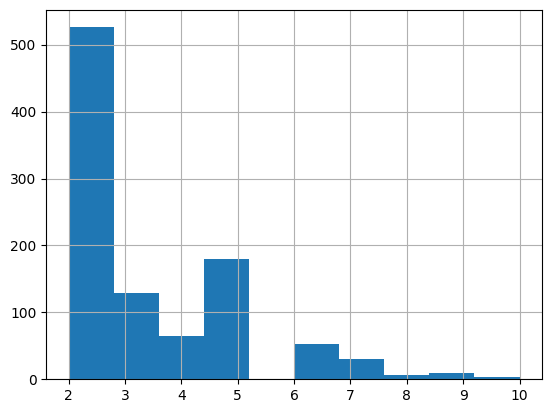

In [9]:
print(fbqa_tset.hops.unique())
fbqa_tset.hops.hist()

In [10]:
fbqa_tset.fillna("", inplace=True)
fbqa_tset.tail(2)

,Question-ID,RawQuestion,ProcessedQuestion,Parses,entities,Answer,hops
3993,FreebaseQA-eval-3993,"Zhou Yang, gold medal winner at the Winter Oly...","zhou yang, gold medal winner at the winter oly...","[{'Parse-Id': 'FreebaseQA-eval-3993.P0', 'Pote...","[[/m/03wctx_, /m/09_bl]]",[short track speed skating],5
3994,FreebaseQA-eval-3994,"Also the name of an English city, Harare, the ...","also the name of an english city, harare, the ...","[{'Parse-Id': 'FreebaseQA-eval-3994.P0', 'Pote...","[[/m/088q4, /m/0fngf], [/m/088q4, /m/0fngf]]","[salisbury, salisbury]",2


In [11]:
# load model answers
for r_set in fbqa.result_set_paths:
    set_name = r_set.split("/")[-1].split(".")[0]
    result_df = pd.read_csv(r_set)
    values = result_df.Model.apply(str).apply(str.lower).apply(lambda t: t.split(",")).values
    values = np.pad(values, (0, 1000 - values.size), constant_values="")
    fbqa_tset[set_name] = values
    fbqa_tset[f"{set_name}_EM"] = fbqa_tset.apply(lambda t: calculate_em_accuracy(t["Answer"], t[set_name]), axis=1)
    fbqa_tset[f"{set_name}_F1"] = fbqa_tset.apply(lambda t: calculate_f1_accuracy(t["Answer"], t[set_name]), axis=1)
fbqa_tset.head(2)

,Question-ID,RawQuestion,ProcessedQuestion,Parses,entities,Answer,hops,bline,bline_EM,bline_F1,...,sbert-kb9_F1,sbert-kb10,sbert-kb10_EM,sbert-kb10_F1,sbert-kb11,sbert-kb11_EM,sbert-kb11_F1,tog-lp-4,tog-lp-4_EM,tog-lp-4_F1
2,FreebaseQA-eval-2,Who directed the films; The Fisher King (1991)...,who directed the films; the fisher king (1991)...,"[{'Parse-Id': 'FreebaseQA-eval-2.P0', 'Potenti...","[[/m/07j6w, /m/07h5d], [/m/04z257, /m/07h5d], ...","[terry gilliam, terry gilliam, terry gilliam, ...",2,[terry gilliam],1,1.0,...,0.0,[nan],0,0.0,[nan],0,0.0,"[('terry gilliam', 3)]",1,0.5
5,FreebaseQA-eval-5,Which country hosted the 1936 Summer Olympic G...,which country hosted the 1936 summer olympic g...,"[{'Parse-Id': 'FreebaseQA-eval-5.P0', 'Potenti...","[[/m/09x3r, /m/0345h], [/m/09x3r, /m/0345h]]","[germany, germany]",2,[germany],1,1.0,...,0.0,[nan],0,0.0,[nan],0,0.0,"[('germany', 1)]",1,0.5


In [12]:
set_names = [r.split("/")[-1].split(".")[0] for r in fbqa.result_set_paths]
set_names

['bline',
 'bline2',
 'kb-path',
 'kb1',
 'kb2',
 'kb3',
 'kb4',
 'kb5',
 'kb6',
 'kb7',
 'kb8',
 'kb9',
 'kb10',
 'kb11',
 'sbert-kb1',
 'sbert-kb2',
 'sbert-kb3',
 'sbert-kb4',
 'sbert-kb5',
 'sbert-kb6',
 'sbert-kb7',
 'sbert-kb8',
 'sbert-kb9',
 'sbert-kb10',
 'sbert-kb11',
 'tog-lp-4']

In [13]:
fbqa_res = fbqa_tset[["hops", *[s+"_EM" for s in set_names], *[s+"_F1" for s in set_names]]]
fbqa_res.head()

,hops,bline_EM,bline2_EM,kb-path_EM,kb1_EM,kb2_EM,kb3_EM,kb4_EM,kb5_EM,kb6_EM,...,sbert-kb3_F1,sbert-kb4_F1,sbert-kb5_F1,sbert-kb6_F1,sbert-kb7_F1,sbert-kb8_F1,sbert-kb9_F1,sbert-kb10_F1,sbert-kb11_F1,tog-lp-4_F1
2,2,1,1,1,1,1,1,0,0,0,...,0.583333,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.500000
5,2,1,1,1,1,1,1,0,0,0,...,1.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.500000
6,3,0,0,1,0,1,1,0,0,0,...,0.571429,0.571429,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.285714
9,2,1,1,1,1,1,1,0,0,0,...,1.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
12,5,0,0,0,1,1,1,1,1,1,...,1.000000,1.000000,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.250000


In [14]:
hop_stats = fbqa_res.groupby(by="hops").sum()
hop_stats["total"] = fbqa_res.groupby(by="hops").apply(lambda t: len(t))
for rset in set_names:
    hop_stats[f"{rset}_p"] = round(hop_stats[f"{rset}_EM"] / hop_stats["total"], 3)
hop_stats

/tmp/ipykernel_144/1837823265.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  hop_stats["total"] = fbqa_res.groupby(by="hops").apply(lambda t: len(t))


,bline_EM,bline2_EM,kb-path_EM,kb1_EM,kb2_EM,kb3_EM,kb4_EM,kb5_EM,kb6_EM,kb7_EM,...,sbert-kb3_p,sbert-kb4_p,sbert-kb5_p,sbert-kb6_p,sbert-kb7_p,sbert-kb8_p,sbert-kb9_p,sbert-kb10_p,sbert-kb11_p,tog-lp-4_p
hops,,,,,,,,,,,,,,,,,,,,,
2,291,291,448,385,389,385,0,0,0,0,...,0.711,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,0.669
3,67,65,94,83,87,85,86,0,0,0,...,0.643,0.651,0.000,0.000,0.000,0.000,0.000,0.000,0.0,0.659
4,30,30,47,38,35,38,38,36,0,0,...,0.594,0.562,0.578,0.000,0.000,0.000,0.000,0.000,0.0,0.578
5,93,96,124,129,123,124,126,126,130,0,...,0.620,0.648,0.615,0.626,0.000,0.000,0.000,0.000,0.0,0.693
6,26,27,33,35,34,31,0,33,33,34,...,0.528,0.000,0.528,0.585,0.547,0.000,0.000,0.000,0.0,0.604
7,8,11,20,18,19,19,0,0,19,18,...,0.700,0.000,0.000,0.600,0.633,0.567,0.000,0.000,0.0,0.567
8,2,2,3,5,4,5,0,0,0,4,...,0.667,0.000,0.000,0.000,0.667,0.667,0.667,0.000,0.0,0.833
9,8,8,7,7,7,7,0,0,0,0,...,0.778,0.000,0.000,0.000,0.000,0.889,0.889,0.889,0.0,0.778
10,4,4,3,4,4,3,0,0,0,0,...,0.500,0.000,0.000,0.000,0.000,0.000,0.500,0.500,0.5,0.750


In [15]:
def get_entity_pairs(cell):
    if cell is None:
        return set()
    t_mid = fbqa.convert_entity(cell.get("TopicEntityMid", None))
    if t_mid is None:
        return set()
    answers = set()
    for a in cell.get("Answers", []):
        a_mid = fbqa.convert_entity(a.get("AnswersMid", None))
        if a_mid is None:
            continue
        answers.add((t_mid, a_mid))
    return answers

In [16]:
fbqa_full = pd.read_json("/datasets/FreebaseQA/FreebaseQA-eval.json")
# 
qs = pd.json_normalize(fbqa_full["Questions"])
prs = pd.json_normalize(qs["Parses"])
# 
prs = prs.applymap(get_entity_pairs)
prs = prs.apply(lambda row: set().union(*row), axis=1)
prs = prs.apply(lambda r: [entity_path_len(p) for p in r])
all_hops = pd.Series(prs.sum())
# from collections import Counter
# Counter(all_hops)
# prs

/tmp/ipykernel_144/4153870859.py:6: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  prs = prs.applymap(get_entity_pairs)


In [17]:
len(fbqa_tset[fbqa_tset.hops == 8])

6

In [18]:
print("FBQA")
data = hop_stats[["total", *[s+"_p" for s in set_names]]]
data = data[data.index < 8]
data

FBQA


,total,bline_p,bline2_p,kb-path_p,kb1_p,kb2_p,kb3_p,kb4_p,kb5_p,kb6_p,...,sbert-kb3_p,sbert-kb4_p,sbert-kb5_p,sbert-kb6_p,sbert-kb7_p,sbert-kb8_p,sbert-kb9_p,sbert-kb10_p,sbert-kb11_p,tog-lp-4_p
hops,,,,,,,,,,,,,,,,,,,,,
2,526,0.553,0.553,0.852,0.732,0.740,0.732,0.000,0.000,0.000,...,0.711,0.000,0.000,0.000,0.000,0.000,0.0,0.0,0.0,0.669
3,129,0.519,0.504,0.729,0.643,0.674,0.659,0.667,0.000,0.000,...,0.643,0.651,0.000,0.000,0.000,0.000,0.0,0.0,0.0,0.659
4,64,0.469,0.469,0.734,0.594,0.547,0.594,0.594,0.562,0.000,...,0.594,0.562,0.578,0.000,0.000,0.000,0.0,0.0,0.0,0.578
5,179,0.520,0.536,0.693,0.721,0.687,0.693,0.704,0.704,0.726,...,0.620,0.648,0.615,0.626,0.000,0.000,0.0,0.0,0.0,0.693
6,53,0.491,0.509,0.623,0.660,0.642,0.585,0.000,0.623,0.623,...,0.528,0.000,0.528,0.585,0.547,0.000,0.0,0.0,0.0,0.604
7,30,0.267,0.367,0.667,0.600,0.633,0.633,0.000,0.000,0.633,...,0.700,0.000,0.000,0.600,0.633,0.567,0.0,0.0,0.0,0.567


In [19]:
def get_n_data(data, set_name, delta=0):
    return [
        data.loc[hop, f"{set_name}{int(hop)+delta}_p"]
        for hop in data.index
    ]

In [20]:
fbqa_sota = 0.842
def plot_sota(ax):
    ax.hlines(fbqa_sota, 2, 7, color="black", linestyles="dashed", label="SOTA")

baseline 0.48 kb-path 0.716


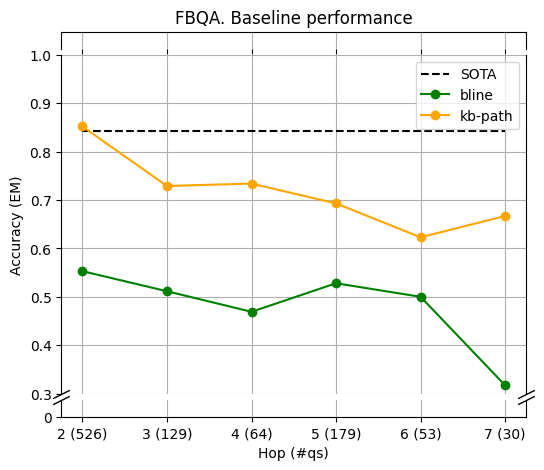

In [43]:
colors = {
    "bline": "green",
    "kb-path": "orange",
}

fig, tax, ax, _ = get_broken_figure(0.3, 1.0)
tax.clear()
tax.grid()
tax.set_yticks([])
# ax.clear()
# ax.grid()
# ax.spines['top'].set_visible(False)
datas = {
    "bline": data[["bline_p", "bline2_p"]].mean(axis=1),
    "kb-path": data["kb-path_p"].values,
}
# 
plot_sota(ax)
for j,k in enumerate(datas.keys()):
    ax.plot(
        data.index.values.astype(int), datas[k],
        color=colors[k], label=k, marker="o",
         
    )
plt.xticks(data.index.values.astype(int), [f"{i} ({data.loc[i, 'total']})" for i in data.index.values])

# plt.tight_layout(pad=1)
tax.set_title("FBQA. Baseline performance")
plt.xlabel("Hop (#qs)")
ax.set_ylabel("Accuracy (EM)")
ax.legend()
plt.grid()
print(
    "baseline", data[["bline_p", "bline2_p"]].mean(axis=1).mean().round(3),
    "kb-path", data["kb-path_p"].mean().round(3),
)
# Display the plot
plt.show()


n-1
0.66
n
0.653
n+1
0.672


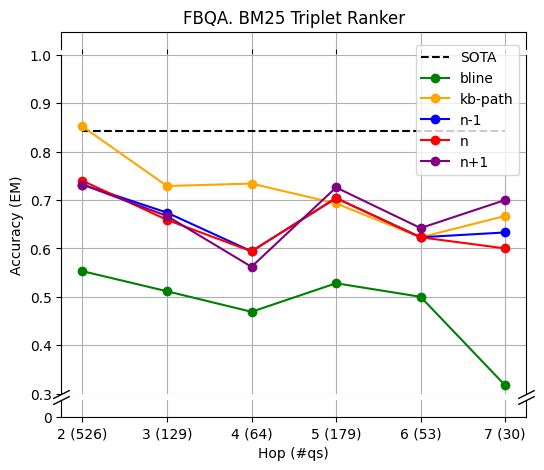

In [ ]:
colors = {
    "bline": "green",
    "kb-path": "orange",
    "n-1": "blue",
    "n": "red",
    "n+1": "purple",
    "tog-lp-1": "brown",
    # "kb5_p": "pink",
    # "kb6_p": "olive",
}

fig, tax, ax, _ = get_broken_figure(0.3, 1)

tax.clear()
tax.grid()
tax.set_yticks([])

nm1_data = get_n_data(data, "kb", -1)
ndata = get_n_data(data, "kb", 0)
np1_data = get_n_data(data, "kb", 1)
datas = {
    "bline": data[["bline_p", "bline2_p"]].mean(axis=1),
    "kb-path": data["kb-path_p"].values,
    "n-1": nm1_data,
    "n": ndata,
    "n+1": np1_data,
}
# 
plot_sota(ax)
for j,k in enumerate(datas.keys()):
    ax.plot(
        data.index.values.astype(int), datas[k],
        color=colors[k], label=k, marker="o",
         
    )
plt.xticks(data.index.values.astype(int), [f"{i} ({data.loc[i, 'total']})" for i in data.index.values])


tax.set_title("FBQA. BM25 Triplet Ranker")
plt.xlabel("Hop (#qs)")
ax.set_ylabel("Accuracy (EM)")
ax.legend(
    loc="upper right",
    bbox_to_anchor=(1, 1.05),
)
plt.grid()
print(
    "n-1", round(sum(nm1_data) / len(nm1_data), 3),
    "n", round(sum(ndata) / len(ndata), 3),
    "n+1", round(sum(np1_data) / len(np1_data), 3),
    sep="\n"
)
# Display the plot
plt.show()


n-1
0.624
n
0.626
n+1
0.613


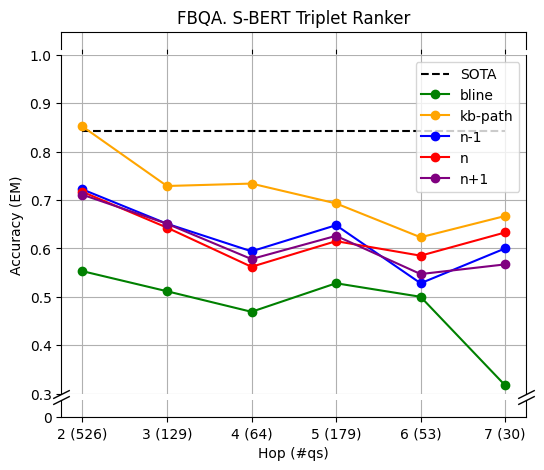

In [47]:
colors = {
    "bline": "green",
    "kb-path": "orange",
    "n-1": "blue",
    "n": "red",
    "n+1": "purple",
    # "kb4_p": "brown",
    # "kb5_p": "pink",
    # "kb6_p": "olive",
}

fig, tax, ax, _ = get_broken_figure(0.3, 1)
tax.clear()
tax.grid()
tax.set_yticks([])

nm1_data = get_n_data(data, "sbert-kb", -1)
ndata = get_n_data(data, "sbert-kb", 0)
np1_data = get_n_data(data, "sbert-kb", 1)
datas = {
    "bline": data[["bline_p", "bline2_p"]].mean(axis=1),
    "kb-path": data["kb-path_p"].values,
    "n-1": nm1_data,
    "n": ndata,
    "n+1": np1_data
}
# 
plot_sota(ax)
for j,k in enumerate(datas.keys()):
    ax.plot(
        data.index.values.astype(int), datas[k],
        color=colors[k], label=k, marker="o",
         
    )
plt.xticks(data.index.values.astype(int), [f"{i} ({data.loc[i, 'total']})" for i in data.index.values])

# ax.set_ylim(0, 1.1)
tax.set_title("FBQA. S-BERT Triplet Ranker")
plt.xlabel("Hop (#qs)")
ax.set_ylabel("Accuracy (EM)")
ax.legend()
plt.grid()
print(
    "n-1", round(sum(nm1_data) / len(nm1_data), 3),
    "n", round(sum(ndata) / len(ndata), 3),
    "n+1", round(sum(np1_data) / len(np1_data), 3),
    sep="\n"
)
# Display the plot
plt.show()


In [57]:
(0.421 + 0.476 + 0.531)/3 

0.476

bm25
0.653
sbert
0.613
tog-lp
0.628


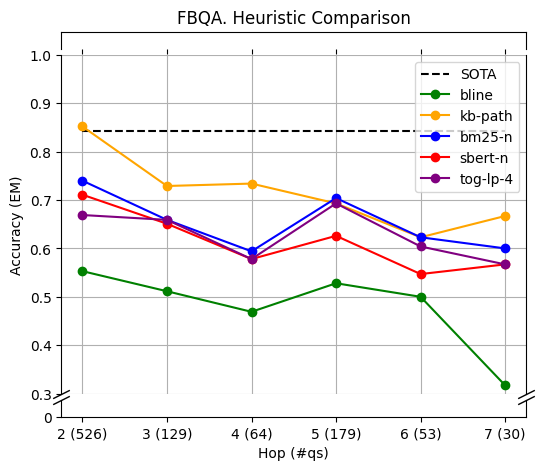

In [51]:
# "": data["tog-lp-1_p"].values
colors = {
    "bline": "green",
    "kb-path": "orange",
    "bm25-n": "blue",
    "sbert-n": "red",
    "tog-lp-4": "purple",
    # "kb4_p": "brown",
    # "kb5_p": "pink",
    # "kb6_p": "olive",
}

fig, tax, ax, _ = get_broken_figure(0.3, 1)
tax.clear()
tax.grid()
tax.set_yticks([])


bm25 = get_n_data(data, "kb", 0)
sbert = get_n_data(data, "sbert-kb", 1)

datas = {
    "bline": data[["bline_p", "bline2_p"]].mean(axis=1),
    "kb-path": data["kb-path_p"].values,
    "bm25-n": bm25,
    "sbert-n": sbert,
    "tog-lp-4": data["tog-lp-4_p"]
}
# 
plot_sota(ax)
for j,k in enumerate(datas.keys()):
    ax.plot(
        data.index.values.astype(int), datas[k],
        color=colors[k], label=k, marker="o",
         
    )
plt.xticks(data.index.values.astype(int), [f"{i} ({data.loc[i, 'total']})" for i in data.index.values])



tax.set_title("FBQA. Heuristic Comparison")
plt.xlabel("Hop (#qs)")
ax.set_ylabel("Accuracy (EM)")
ax.legend()
tax.grid()
print(
    "bm25", round(sum(bm25) / len(bm25), 3),
    "sbert", round(sum(sbert) / len(sbert), 3),
    "tog-lp", round(sum(data["tog-lp-4_p"]) / len(data["tog-lp-4_p"]), 3),
    sep="\n"
)
# Display the plot
plt.show()


In [179]:
fbqa_res.groupby("hops").sum()

,bline_EM,bline2_EM,kb-path_EM,kb1_EM,kb2_EM,kb3_EM,kb4_EM,kb5_EM,kb6_EM,kb7_EM,...,sbert-kb3_F1,sbert-kb4_F1,sbert-kb5_F1,sbert-kb6_F1,sbert-kb7_F1,sbert-kb8_F1,sbert-kb9_F1,sbert-kb10_F1,sbert-kb11_F1,tog-lp-4_F1
hops,,,,,,,,,,,,,,,,,,,,,
2,291,291,448,385,389,385,0,0,0,0,...,365.404008,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,184.745421
3,67,65,94,83,87,85,86,0,0,0,...,81.898837,82.525815,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,42.891090
4,30,30,47,38,35,38,38,36,0,0,...,40.900000,37.281818,39.387374,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,20.591270
5,93,96,124,129,123,124,126,126,130,0,...,113.974802,120.773639,114.735913,116.348054,0.000000,0.00000,0.000000,0.000000,0.000000,65.835065
6,26,27,33,35,34,31,0,33,33,34,...,29.061778,0.000000,30.346825,30.883333,30.504444,0.00000,0.000000,0.000000,0.000000,16.941703
7,8,11,20,18,19,19,0,0,19,18,...,21.935566,0.000000,0.000000,19.496970,20.496970,18.74697,0.000000,0.000000,0.000000,9.382201
8,2,2,3,5,4,5,0,0,0,4,...,3.500000,0.000000,0.000000,0.000000,3.583333,3.50000,3.583333,0.000000,0.000000,2.500000
9,8,8,7,7,7,7,0,0,0,0,...,7.000000,0.000000,0.000000,0.000000,0.000000,8.00000,8.000000,8.000000,0.000000,3.500000
10,4,4,3,4,4,3,0,0,0,0,...,2.000000,0.000000,0.000000,0.000000,0.000000,0.00000,2.578512,2.537037,2.537037,1.611111


In [123]:
fbqa_res.columns

Index(['hops', 'bline_EM', 'bline2_EM', 'kb-path_EM', 'kb1_EM', 'kb2_EM',
       'kb3_EM', 'kb4_EM', 'kb5_EM', 'kb6_EM', 'kb7_EM', 'kb8_EM', 'kb9_EM',
       'kb10_EM', 'kb11_EM', 'sbert-kb1_EM', 'sbert-kb2_EM', 'sbert-kb3_EM',
       'sbert-kb4_EM', 'sbert-kb5_EM', 'sbert-kb6_EM', 'sbert-kb7_EM',
       'sbert-kb8_EM', 'sbert-kb9_EM', 'sbert-kb10_EM', 'sbert-kb11_EM',
       'tog-lp-4_EM', 'bline_F1', 'bline2_F1', 'kb-path_F1', 'kb1_F1',
       'kb2_F1', 'kb3_F1', 'kb4_F1', 'kb5_F1', 'kb6_F1', 'kb7_F1', 'kb8_F1',
       'kb9_F1', 'kb10_F1', 'kb11_F1', 'sbert-kb1_F1', 'sbert-kb2_F1',
       'sbert-kb3_F1', 'sbert-kb4_F1', 'sbert-kb5_F1', 'sbert-kb6_F1',
       'sbert-kb7_F1', 'sbert-kb8_F1', 'sbert-kb9_F1', 'sbert-kb10_F1',
       'sbert-kb11_F1', 'tog-lp-4_F1'],
      dtype='object')

In [226]:
def split_index(index):
    set_name, score = index.split("_")
    depth = 0
    if "kb" in set_name and "path" not in set_name:
        if "sbert" in set_name:
            set_name, depth = set_name.split("-")
            depth = int(depth[2:])
        else:
            depth = int(set_name[2:])
            set_name = "kb"
    return set_name, depth, score

In [256]:
t_hop_stats = fbqa_res.groupby(by="hops").mean()
t_hop_stats

,bline_EM,bline2_EM,kb-path_EM,kb1_EM,kb2_EM,kb3_EM,kb4_EM,kb5_EM,kb6_EM,kb7_EM,...,sbert-kb3_F1,sbert-kb4_F1,sbert-kb5_F1,sbert-kb6_F1,sbert-kb7_F1,sbert-kb8_F1,sbert-kb9_F1,sbert-kb10_F1,sbert-kb11_F1,tog-lp-4_F1
hops,,,,,,,,,,,,,,,,,,,,,
2,0.553232,0.553232,0.851711,0.731939,0.739544,0.731939,0.000000,0.000000,0.000000,0.000000,...,0.694684,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.351227
3,0.519380,0.503876,0.728682,0.643411,0.674419,0.658915,0.666667,0.000000,0.000000,0.000000,...,0.634875,0.639735,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.332489
4,0.468750,0.468750,0.734375,0.593750,0.546875,0.593750,0.593750,0.562500,0.000000,0.000000,...,0.639062,0.582528,0.615428,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.321739
5,0.519553,0.536313,0.692737,0.720670,0.687151,0.692737,0.703911,0.703911,0.726257,0.000000,...,0.636731,0.674713,0.640983,0.649989,0.000000,0.000000,0.000000,0.000000,0.000000,0.367794
6,0.490566,0.509434,0.622642,0.660377,0.641509,0.584906,0.000000,0.622642,0.622642,0.641509,...,0.548335,0.000000,0.572582,0.582704,0.575556,0.000000,0.000000,0.000000,0.000000,0.319655
7,0.266667,0.366667,0.666667,0.600000,0.633333,0.633333,0.000000,0.000000,0.633333,0.600000,...,0.731186,0.000000,0.000000,0.649899,0.683232,0.624899,0.000000,0.000000,0.000000,0.312740
8,0.333333,0.333333,0.500000,0.833333,0.666667,0.833333,0.000000,0.000000,0.000000,0.666667,...,0.583333,0.000000,0.000000,0.000000,0.597222,0.583333,0.597222,0.000000,0.000000,0.416667
9,0.888889,0.888889,0.777778,0.777778,0.777778,0.777778,0.000000,0.000000,0.000000,0.000000,...,0.777778,0.000000,0.000000,0.000000,0.000000,0.888889,0.888889,0.888889,0.000000,0.388889
10,1.000000,1.000000,0.750000,1.000000,1.000000,0.750000,0.000000,0.000000,0.000000,0.000000,...,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.644628,0.634259,0.634259,0.402778


In [263]:
# df_copy = fbqa_res.groupby("hops").mean()
df_copy = t_hop_stats[[c for c in t_hop_stats.columns if ("EM" in c or "F1" in c)]].copy()
new_columns = [*[split_index(col) for col in df_copy.columns]]
# print(new_columns)
df_copy.columns = pd.MultiIndex.from_tuples(new_columns)
# df_copy.set_index(['method', 'depth', 'metric'], inplace=True)
df_copy = df_copy.T
df_copy.index.names = ['Method', 'Hops', 'Metric']
df_copy
df_pivot = df_copy.unstack(level='Metric')

d = df_pivot
# [[8,9,10]]
d
# print(d.reorder_levels(["Method", "Hops"]).to_latex(float_format="%.3f"))

hops                 2                   3                   4             \
Metric               EM        F1        EM        F1        EM        F1   
Method   Hops                                                               
bline    0     0.553232  0.648686  0.519380  0.610329  0.468750  0.586116   
bline2   0     0.553232  0.649453  0.503876  0.597974  0.468750  0.587101   
kb       1     0.731939  0.770532  0.643411  0.649824  0.593750  0.649988   
         2     0.739544  0.778470  0.674419  0.670449  0.546875  0.639050   
         3     0.731939  0.768132  0.658915  0.660739  0.593750  0.665092   
         4     0.000000  0.000000  0.666667  0.671419  0.593750  0.665092   
         5     0.000000  0.000000  0.000000  0.000000  0.562500  0.636446   
         6     0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
         7     0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
         8     0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
         9     0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
         10    0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
         11    0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
kb-path  0     0.851711  0.884910  0.728682  0.740529  0.734375  0.752655   
sbert    1     0.722433  0.732838  0.643411  0.649863  0.593750  0.645226   
         2     0.716730  0.692328  0.651163  0.658391  0.546875  0.604403   
         3     0.711027  0.694684  0.643411  0.634875  0.593750  0.639062   
         4     0.000000  0.000000  0.651163  0.639735  0.562500  0.582528   
         5     0.000000  0.000000  0.000000  0.000000  0.578125  0.615428   
         6     0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
         7     0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
         8     0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
         9     0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
         10    0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
         11    0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
tog-lp-4 0     0.669202  0.351227  0.658915  0.332489  0.578125  0.321739   

hops                 5                   6                   7             \
Metric               EM        F1        EM        F1        EM        F1   
Method   Hops                                                               
bline    0     0.519553  0.630838  0.490566  0.524080  0.266667  0.475188   
bline2   0     0.536313  0.630289  0.509434  0.540960  0.366667  0.524881   
kb       1     0.720670  0.749299  0.660377  0.684681  0.600000  0.646470   
         2     0.687151  0.731267  0.641509  0.657053  0.633333  0.675191   
         3     0.692737  0.735495  0.584906  0.636977  0.633333  0.699370   
         4     0.703911  0.740092  0.000000  0.000000  0.000000  0.000000   
         5     0.703911  0.743673  0.622642  0.659837  0.000000  0.000000   
         6     0.726257  0.756457  0.622642  0.662700  0.633333  0.696195   
         7     0.000000  0.000000  0.641509  0.654108  0.600000  0.682068   
         8     0.000000  0.000000  0.000000  0.000000  0.700000  0.785084   
         9     0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
         10    0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
         11    0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
kb-path  0     0.692737  0.718926  0.622642  0.659978  0.666667  0.706494   
sbert    1     0.614525  0.638464  0.603774  0.610692  0.633333  0.688090   
         2     0.648045  0.667814  0.509434  0.537839  0.700000  0.730058   
         3     0.620112  0.636731  0.528302  0.548335  0.700000  0.731186   
         4     0.648045  0.674713  0.000000  0.000000  0.000000  0.000000   
         5     0.614525  0.640983  0.528302  0.572582  0.000000  0.000000   
         6     0.625698  0.649989  0.584906  0.582704  0.600000  0.64989

## 18.02.2025:


Trade-off between:
- Internal knowledge
- Amount of introduced data

Delicate balance: introducing knowledge initially shadows the internal knowledge, but given correctly retrieved knowledge, the accuracy is good

Bias towards training data [link](https://proceedings.neurips.cc/paper_files/paper/2024/file/2a617efee5815f12b405d40569dea0a5-Paper-Datasets_and_Benchmarks_Track.pdf)



### TODO: Directly do 7 hops (n-1, n, n+1)

Models may vary in their bias towards certain data in specific domains

As a consequence: the ideal solution is to provide relevant knowledge with relationships and biases accounted for.

^ That's a way of addressing the issue
The idea is to minimize the bias introduced in training data (possibly by introducing data ONLY relevant to the subject and therefore overriding the internal bias)

## By Tuesday (25.02), do the 

- Intro
- related work (finem)

- preliminary data
- graph
- model
- baseline bias
- talk about the results
- kb results


- why worth looking into knowledge bases (literature + numbers)

- Given the justification and the pattern holding, introduce the need for a retrieval technique

- link prediction, tail pruning

- consider answering on an explicit path (would it still answer correctly)